# Install dependencies

```
!pip install tqdm
```

In [1]:
#!pip install tqdm

In [2]:
from pathlib import Path

from matplotlib import pyplot as plt
from torch2trt import torch2trt, TRTModule
from tqdm.auto import tqdm
import PIL
import cv2
import numpy as np
import pandas as pd
import torch
import torchvision
import torchvision.transforms as transforms

# Config

In [3]:
LOAD_MODEL = None  # None or filename.pth (must exist inside models/)
SAVE_MODEL = 'cida_javi_cristal_ep15_lr3e-4'      # filename.path
BS = 32             # batch size
EPOCHS = 15        # number of epochs
LR = 3e-4          # learning rate
SZ = 224           # model input image size
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

# Train dataset transforms
TRAIN_TRANSFORMS = transforms.Compose([
    transforms.ColorJitter(0.2, 0.2, 0.2, 0.2),
    transforms.Resize((SZ, SZ)),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

# Validation dataset transforms
VALID_TRANSFORMS = transforms.Compose([
    transforms.Resize((SZ, SZ)),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

# Dataset

In [4]:
class XYDataset(torch.utils.data.Dataset):
    def __init__(self, directory, transform=None, random_hflip=False):
        super(XYDataset, self).__init__()
        self.directory = directory
        self.transform = transform
        self.random_hflip = random_hflip
        df_p = Path(directory) / 'labels.csv'
        self.data = pd.read_csv(df_p).to_dict()
            
    def __len__(self):
        return len(self.data['filename'])
    
    def __getitem__(self, idx):
        image = cv2.imread(f"{self.directory}/{self.data['filename'][idx]}", cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        width, height = image.shape[:2]
        #print(width, height)
        x = 2.0 * (self.data['x'][idx] / width - 0.5) # -1 left, +1 right
        y = 2.0 * (self.data['y'][idx] / height - 0.5) # -1 top, +1 bottom

        # Hflip
        if self.random_hflip and float(np.random.random(1)) > 0.5:
            image = image[:,::-1,:].copy()
            x = -x
       
        # To PIL + transforms
        image = PIL.Image.fromarray(image)
        if self.transform is not None:
            image = self.transform(image)
        
        # TODO: 0 -> category index
        return np.array(image), torch.Tensor([x, y])


In [5]:
train_ds = XYDataset('train_dataset', transform=TRAIN_TRANSFORMS, random_hflip=True)
valid_ds = XYDataset('valid_dataset', transform=VALID_TRANSFORMS)

# Data loaders

In [6]:
train_dl = torch.utils.data.DataLoader(
    train_ds,
    batch_size=BS,
    shuffle=True
)

valid_dl = torch.utils.data.DataLoader(
    valid_ds,
    batch_size=BS,
)

# Create and optionally load model

In [7]:
if LOAD_MODEL:
    model = torchvision.models.resnet18(pretrained=False)
else:
    model = torchvision.models.resnet18(pretrained=True)

model.fc = torch.nn.Linear(512, 2)

if LOAD_MODEL:
    model.load_state_dict(torch.load('models/' + LOAD_MODEL + '.pth'))
    print(f"Loaded {LOAD_MODEL}")

In [8]:
model.cuda();

# Optimizer

In [9]:
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

# Loss function

In [10]:
train_loss_func = torch.nn.MSELoss()
valid_loss_func = torch.nn.MSELoss(reduction='sum')

# Training/eval function

## ¡OJO! 

Apagar todos los kernels de jupyter lab excepto este para dejar RAM libre para el entrenamiento (la RAM del jetson se comparte entre la CPU y la GPU). Evitar el swap, que es muy lento y daña la SD a largo plazo.

Se puede monitorizar el uso de ram del jetson desde un terminal `ssh` con:

```
sudo jtop
```

In [11]:
epoch_pbar = tqdm(range(EPOCHS))

for epoch in epoch_pbar:
    epoch_pbar.set_postfix(epoch=epoch)

    # Train
    model.train()
    train_pbar = tqdm(train_dl, position=0, leave=False)
    for images, targ in train_pbar:
        images = images.cuda()
        targ = targ.cuda()
        
        optimizer.zero_grad()
        pred = model(images)
        train_loss = train_loss_func(pred, targ)
        train_loss.backward()
        optimizer.step()
        
        train_pbar.set_postfix(
            train_loss=f'{train_loss.detach().cpu().item():.6f}', 
        )
        
    # Validate
    model.eval()
    valid_loss = 0
    valid_pbar = tqdm(valid_dl, leave=False)
    for images, targ in valid_pbar:
        images = images.cuda()
        targ = targ.cuda()
        with torch.no_grad():
            pred = model(images)
            valid_loss += valid_loss_func(pred, targ)
    valid_loss /= len(valid_ds)
    print(f'epoch={epoch} valid_loss={valid_loss.detach().cpu().item():.6f}')

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

epoch=0 valid_loss=0.263721


  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

epoch=1 valid_loss=0.140412


  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

epoch=2 valid_loss=0.133053


  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

epoch=3 valid_loss=0.096908


  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

epoch=4 valid_loss=0.125335


  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

epoch=5 valid_loss=0.064068


  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

epoch=6 valid_loss=0.067678


  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

epoch=7 valid_loss=0.056603


  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

epoch=8 valid_loss=0.061064


  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

epoch=9 valid_loss=0.080906


  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

epoch=10 valid_loss=0.066732


  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

epoch=11 valid_loss=0.086854


  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

epoch=12 valid_loss=0.072018


  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

epoch=13 valid_loss=0.072597


  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

epoch=14 valid_loss=0.059992


# Save model

In [12]:
torch.save(model.state_dict(), 'models/' + SAVE_MODEL + '.pth')

In [13]:
model.load_state_dict(torch.load('models/' + SAVE_MODEL + '.pth'))

<All keys matched successfully>

# Show results

In [14]:
def denorm(x):
    x = x.permute(1, 2, 0) * torch.tensor(IMAGENET_STD) + torch.tensor(IMAGENET_MEAN)
    x = x * 255
    x = torch.clamp(x, 0, 255).to(torch.uint8)
    x = x.numpy()
    return x

def show_batch(images, targ, pred=None):
    ncols = 4
    nrows = (images.shape[0] + ncols - 1) // ncols
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16,4*nrows))
    for i in range(images.shape[0]):
        if nrows > 1:
            ax = axes[i%nrows,i//nrows]
        else:
            ax = axes[i]
        img = denorm(images[i])
        x, y = targ[i].tolist()
        ix = int((x + 1) / 2 * (SZ - 1))
        iy = int((y + 1) / 2 * (SZ - 1))
        cv2.circle(img, (ix, iy), 8, (0, 255, 0), 2)
        if pred is not None:
            x, y = pred[i].tolist()
            ix = int((x + 1) / 2 * (SZ - 1))
            iy = int((y + 1) / 2 * (SZ - 1))
            cv2.circle(img, (ix, iy), 6, (255, 127, 255), 2)
            
        ax.imshow(img)
        #ax.title.set_text(label)

In [18]:
test_dl = torch.utils.data.DataLoader(
    valid_ds,
    batch_size=BS,
    shuffle=True
)

In [22]:
images, targ = next(iter(test_dl))
#images = images[:8]
#targ = targ[:8]

In [23]:
model.cuda().eval()
with torch.no_grad():
    pred = model(images.cuda())

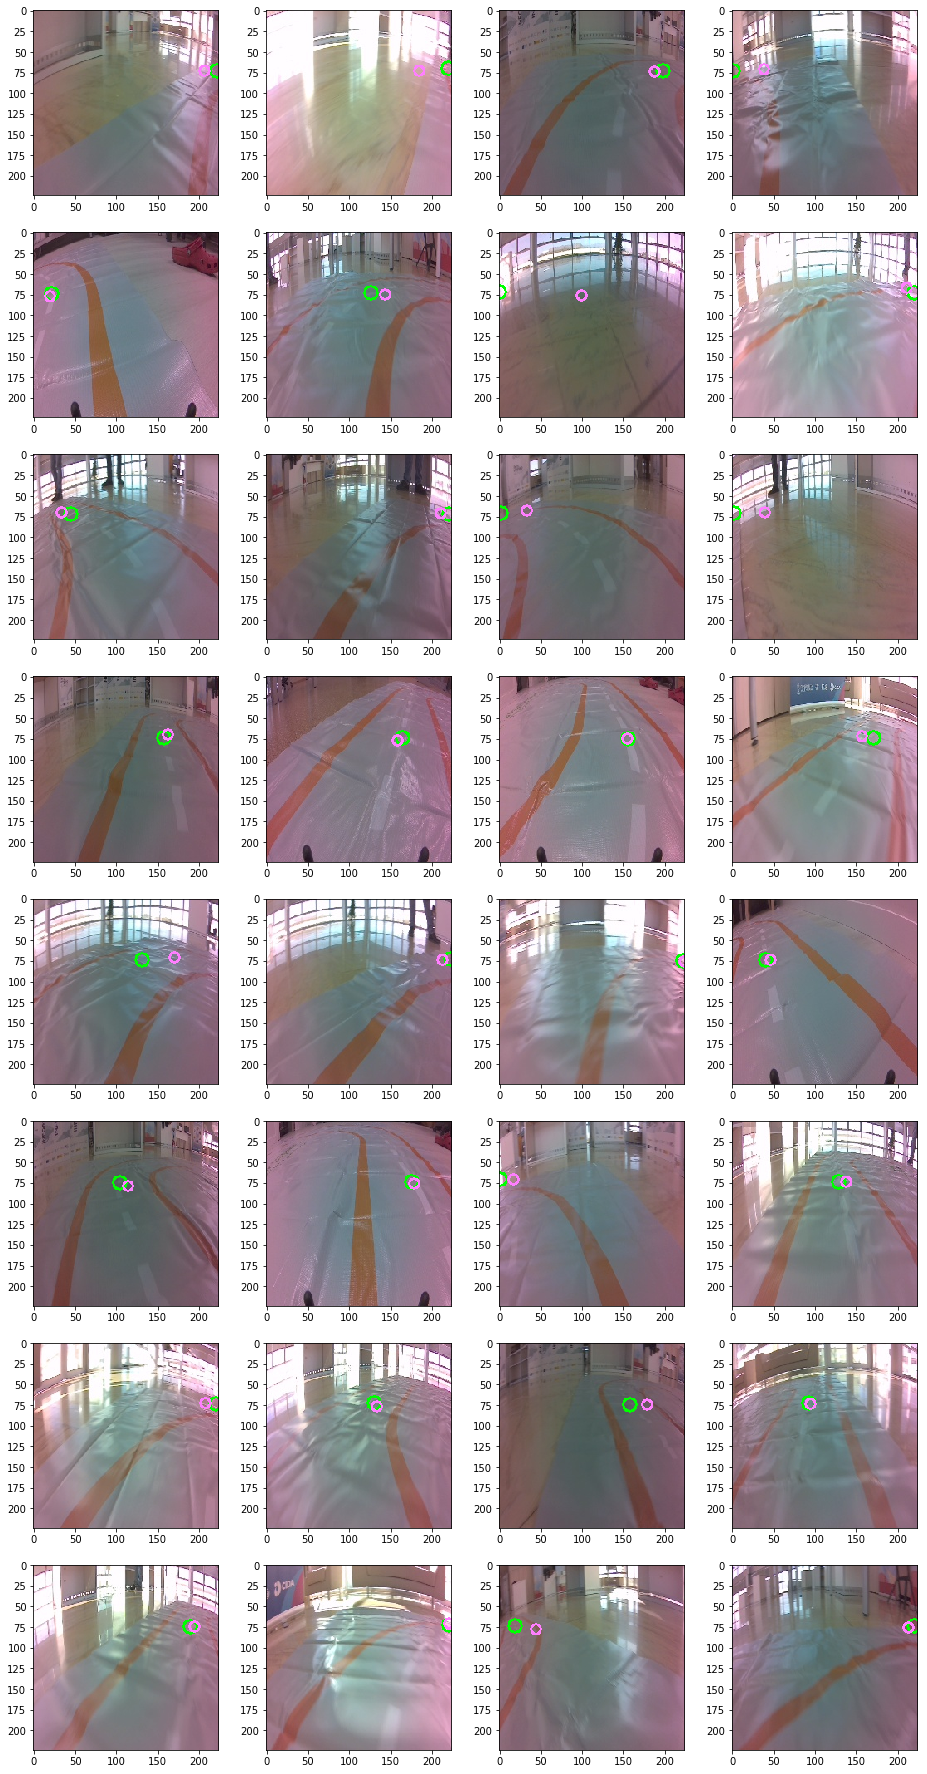

In [24]:
show_batch(images, targ, pred)

# Convert to TRT

In [25]:
model = model.cuda().eval().half()

In [26]:
data = torch.zeros((1, 3, SZ, SZ)).cuda().half()
model_trt = torch2trt(model, [data], fp16_mode=True)

# Save TRT optimized model

In [27]:
torch.save(model_trt.state_dict(), 'models/' + SAVE_MODEL + '_trt.pth')

In [28]:
model_trt = TRTModule()
model_trt.load_state_dict(torch.load('models/' + SAVE_MODEL + '_trt.pth'))

<All keys matched successfully>

In [29]:
model_trt.eval()
with torch.no_grad():
    pred = []
    for i in images:
        pred.append(model_trt(i[None,:].cuda().half()))
    pred = torch.cat(pred)

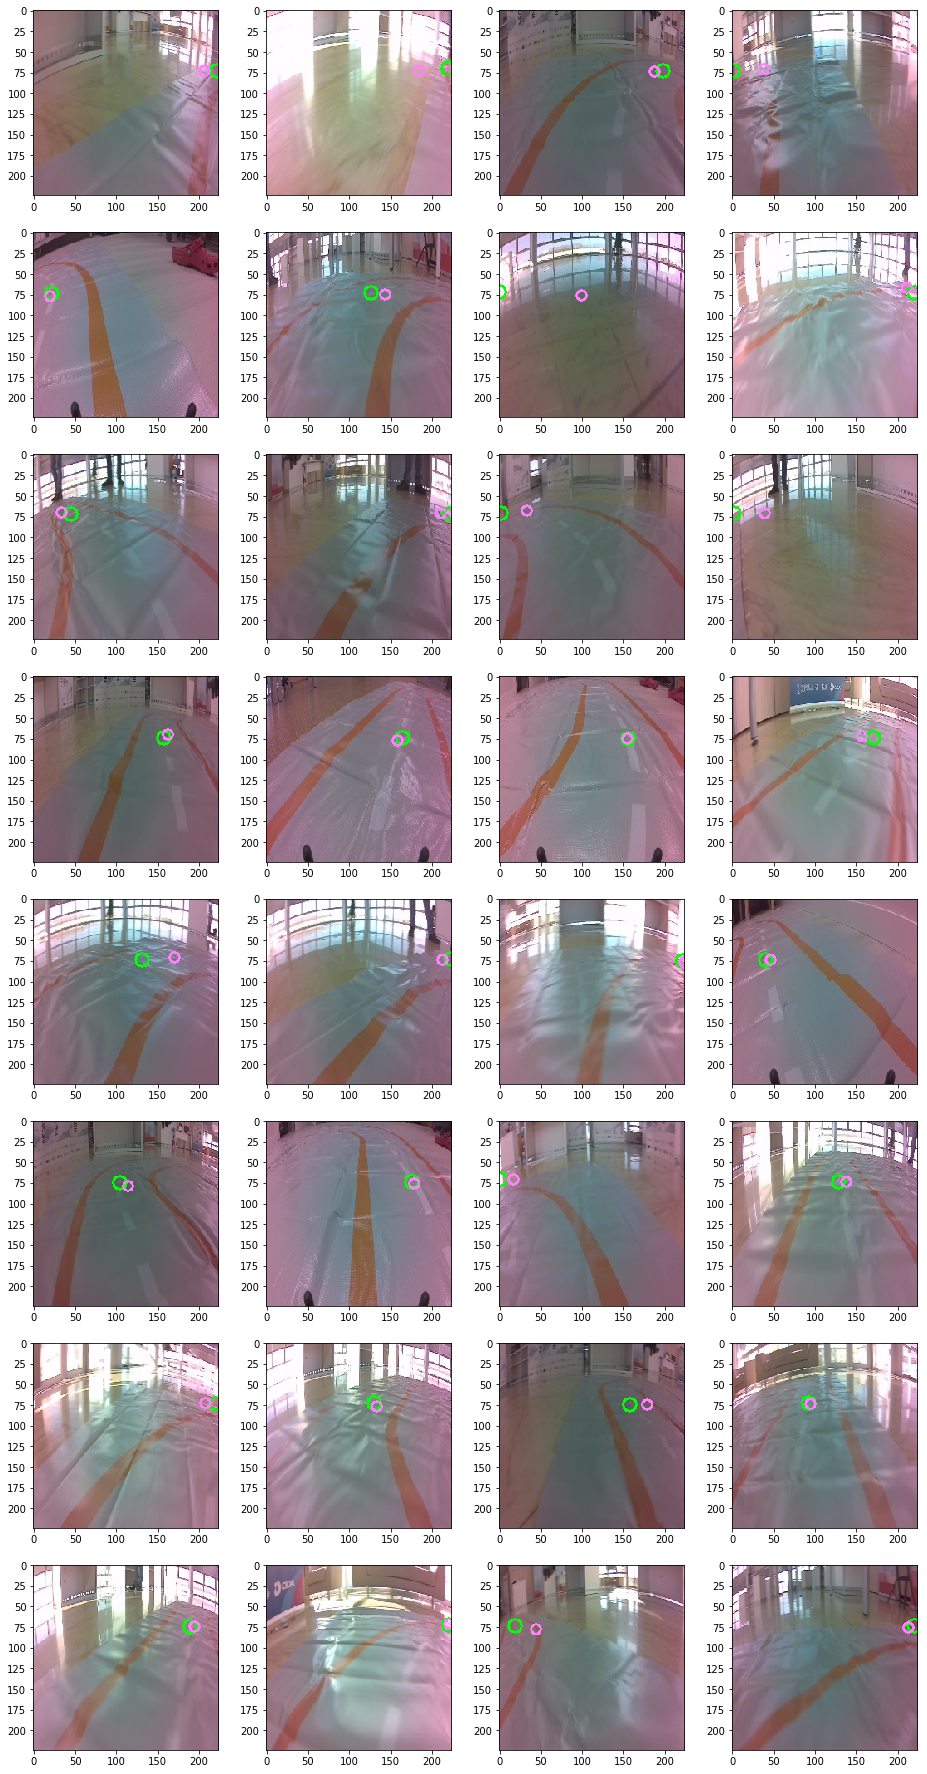

In [30]:
show_batch(images, targ, pred)

# Torch vs TRT benchmark
Expected results:

```
model(one_image)
33.8 ms ± 1.76 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
```

```
model_trt(one_image)
3.02 ms ± 1.58 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
```

In [31]:
one_image = images[:1].cuda().half()

In [32]:
%%timeit
model(one_image)

33.8 ms ± 1.76 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [33]:
%%timeit
model_trt(one_image)

3.02 ms ± 1.58 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
